In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))

%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis


In [2]:
from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.task_metrics import props

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty

from rdkit.Chem.Draw import IPythonConsole

In [3]:
props.similarity

<function properties.similarity(a, b)>

In [4]:
feat2smiles

<function molgen.dataloading.feat2smiles.feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, include_charge=False)>

# Get some predicted molecules from the model

In [5]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

model = "transformer2"
model_iter = 26 

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)

molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
print (molopt, config)

molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
print (molopt_decoder, config_decoder)

MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=50, bias=False)
    (W_message_h): Linear(in_features=50, out_features=50, bias=False)
    (W_message_o): Linear(in_features=143, out_features=50, bias=True)
    (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=50, out_features=50, bias=True)
  (opt1): Linear(in_features=50, out_features=50, bias=True)
) Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer2_decode', init_model='transformer2', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_so

In [6]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 96, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)

for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [7]:
x_embedding, x_delta_hat = molopt.forward(X)
results_logits = molopt_decoder.forward(x_embedding + x_delta_hat, Y)
results_labels = molopt_decoder.discretize(*results_logits)

symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [8]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

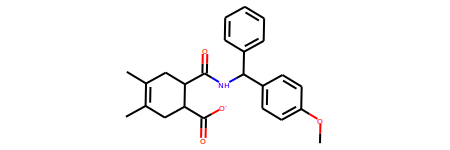

In [9]:
Chem.MolFromSmiles(initial_smiles[0], sanitize = False)

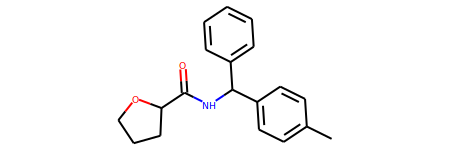

In [10]:
Chem.MolFromSmiles(target_smiles[0], sanitize = False)

In [11]:
bond_idx = 0
pred_smiles = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols_labels_crt = symbols_labels[st:st+le]
    charges_labels_crt = charges_labels[st:st+le]
    bonds_labels_crt = bonds_labels[bond_idx:bond_idx+le*le].view(le, le, -1)
    
    pred_smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols_labels_crt, charges_labels_crt, bonds_labels_crt))
    
    bond_idx += le * le

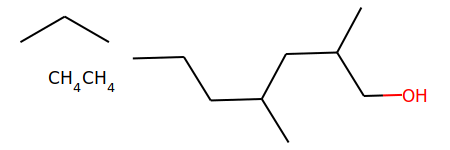

In [12]:
Chem.MolFromSmiles(pred_smiles[3], sanitize = False)

# Wengong metrics

In [29]:
idx = 3
pmol = pred_smiles[idx]
xmol = initial_smiles[idx]
ymol = target_smiles[idx]

print("Similarity scores")
print("Y similarity:", props.similarity(ymol, xmol))
print("Yhat similar:", props.similarity(pmol, xmol))
print("Y-Yh similar:", props.similarity(pmol, ymol))
print()
print("QED scores")
print("X QED score", props.qed(xmol))
print("Y QED score", props.qed(ymol))
print("Yhat QED sc", props.qed(pmol))
print()
print("Penalized LogP")
print("X penlogp", props.penalized_logp(xmol))
print("Y penlogp", props.penalized_logp(ymol))
print("Yhat penl", props.penalized_logp(pmol))
# print("DRD scores")
# print("X DRD score", props.drd2(xmol))
# print("Y DRD score", props.drd2(ymol))
# print("Yhat DRD sc", props.drd2(pmol))



Similarity scores
Y similarity: 0.40350877192982454
Yhat similar: 0.1
Y-Yh similar: 0.125

QED scores
X QED score 0.795289847612256
Y QED score 0.9010565120735919
Yhat QED sc 0.6807624251479036

Penalized LogP
X penlogp 1.5078776205100688
Y penlogp 1.6231857337123865
Yhat penl 1.6572227558369357


# Pani metrics

In [109]:
from molgen.metrics.mol_metrics import MolMetrics

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)

# Y.get_graph_outputs()

In [110]:
pred_pack = (results_labels, results_logits, Y.scope)
metrics.measure_batch(pred_pack, Y.get_graph_outputs())

{'molecular_disconnected_validity': 25.0,
 'molecular_validity': 1.0416666666666667,
 'symbol_accuracy': 87.0136186770428,
 'connected_components': 3.7395833333333335,
 'invalid_valency_nodes': 8.852140077821012}

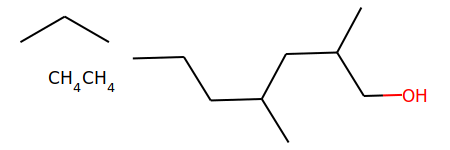

In [95]:
for s in pred_smiles:
    try:
        if len(Chem.GetMolFrags(Chem.MolFromSmiles(s))) == 1:
            break
    except:
        continue
        
Chem.MolFromSmiles(s)

In [96]:
for i, s in enumerate(pred_smiles):
    try:
        print (i, len(Chem.GetMolFrags(Chem.MolFromSmiles(s))))
    except:
        print (i, "N/A")

0 N/A
1 3
2 7
3 4


In [97]:
# debug a particular molecule
bond_idx = 0
pred_smiles = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols_labels_crt = symbols_labels[st:st+le]
    charges_labels_crt = charges_labels[st:st+le]
    bonds_labels_crt = bonds_labels[bond_idx:bond_idx+le*le].view(le, le, -1)
    
    pred_smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols_labels_crt, charges_labels_crt, bonds_labels_crt))
    
    bond_idx += le * le
    
    if mol_idx == idx:
        break

In [98]:
metrics.sample_invalid_valency_nodes(symbols_labels_crt, charges_labels_crt, bonds_labels_crt)

15

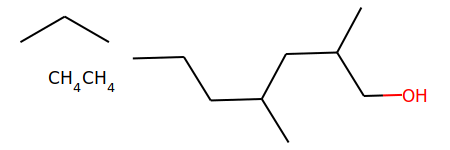

In [99]:
Chem.MolFromSmiles(pred_smiles[idx])

In [100]:
len(symbols_labels_crt)

15

In [108]:
import torch 

invalid_atoms = 0
for atom_idx, atom in enumerate(symbols_labels_crt):
    print (metrics.SYMBOLS[atom])
    if metrics.SYMBOLS[atom] == 'UNK':
        invalid_atoms += 1
        continue
    effVal = torch.sum(bonds_labels_crt[atom_idx]).item()
    maxVal = Chem.GetPeriodicTable().GetValenceList(metrics.SYMBOLS[atom])[-1]
    print (effVal, maxVal)
    if maxVal > 0 and effVal > maxVal:
        invalid_atoms += 1

O
56 2
C
52 4
C
56 4
C
52 4
C
56 4
C
60 4
C
56 4
C
52 4
C
56 4
C
52 4
C
52 4
C
48 4
C
60 4
C
48 4
C
56 4


In [111]:
sum([metrics.bond_weights[x] for x in bonds_labels_crt[atom_idx]])

tensor([1.])

In [125]:
from mol_opt.task_metrics import measure_task

In [137]:
measure_task(X,pred_pack)

{'X-Yh similar': 0.016314177670246437,
 'Yhat QED': 0.16843420756360675,
 'Yhat penlog': -75.60692417297243}